In [2]:
import csv
import numpy as np
import os
import pandas as pd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import ticker
from scipy.stats import spearmanr
from torch.utils.tensorboard import SummaryWriter

# from src.utils import Plotting 
# from src.utils import Dataloader
# from src.utils import EarlyStopping
import datetime

import seaborn as sns

from sklearn.metrics import mean_absolute_error

In [3]:
seed=999
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [5]:
fname="/gpfs/work/sharmas/mc-snow-data/Timeseries_data.csv"

In [6]:
df=pd.read_csv(fname)

In [7]:
df.head()

,time,Lc,Nc,Zc,Lr,Nr,Zr,auto_num,auto_mass,accr_num,accr_mass,self_cloud,self_rain,nsp,lwc0,rm,nu_gam,mu_gam
0,20.0,0.000998,70616000.0,1.982130e-14,6.940890e-15,0.000026,1.825170e-24,0.000001,3.470440e-16,0.000000,0.000000e+00,5975.81,0.0,27860.0,0.001,0.000015,1.5,1.0
1,40.0,0.000998,70480600.0,1.991330e-14,1.664520e-10,0.579694,4.779850e-20,0.028983,8.227570e-12,0.028652,9.469380e-14,6770.35,0.0,27860.0,0.001,0.000015,1.5,1.0
2,60.0,0.000998,70354000.0,2.000490e-14,1.984290e-10,0.598563,6.586050e-20,0.000943,2.523660e-13,0.086980,1.346460e-12,6327.91,0.0,27860.0,0.001,0.000015,1.5,1.0
3,80.0,0.000998,70238000.0,2.009590e-14,2.407490e-10,0.663857,8.806710e-20,0.003265,8.900880e-13,0.030139,1.225930e-12,5801.94,0.0,27860.0,0.001,0.000015,1.5,1.0
4,100.0,0.000998,70093100.0,2.021030e-14,2.914650e-10,0.749375,1.155360e-19,0.004276,1.142440e-12,0.097133,1.393350e-12,7244.83,0.0,27860.0,0.001,0.000015,1.5,1.0


In [8]:
epsilon=1e-15

In [9]:
df["Xc"]=(df['Lc']/df['Nc'])
df["tau"]=(df['Lr']/df['lwc0'])

In [10]:
kcc = 9.44e9
kcr = 5.78
xstar = 2.6e-10 
rhow = 1e3

In [11]:
xc0 = np.pi*rhow/6. * (df['rm']*2)**3 

In [21]:
auto_fac = kcc/(20*xstar) * (df['nu_gam']+2.0)*(df['nu_gam']+4.0)/(df['nu_gam']+1.0)**2 * df['lwc0']**2 * (xc0**2)
auto_norm=np.log((df['auto_mass']/auto_fac+epsilon).to_numpy())

In [22]:
accr_norm=np.log((df['accr_mass']/auto_fac+epsilon).to_numpy())

In [23]:
df.head()

,time,Lc,Nc,Zc,Lr,Nr,Zr,auto_num,auto_mass,accr_num,accr_mass,self_cloud,self_rain,nsp,lwc0,rm,nu_gam,mu_gam,Xc,tau
0,20.0,0.000998,70616000.0,1.982130e-14,6.940890e-15,0.000026,1.825170e-24,0.000001,3.470440e-16,0.000000,0.000000e+00,5975.81,0.0,27860.0,0.001,0.000015,1.5,1.0,1.413810e-11,6.940890e-12
1,40.0,0.000998,70480600.0,1.991330e-14,1.664520e-10,0.579694,4.779850e-20,0.028983,8.227570e-12,0.028652,9.469380e-14,6770.35,0.0,27860.0,0.001,0.000015,1.5,1.0,1.416526e-11,1.664520e-07
2,60.0,0.000998,70354000.0,2.000490e-14,1.984290e-10,0.598563,6.586050e-20,0.000943,2.523660e-13,0.086980,1.346460e-12,6327.91,0.0,27860.0,0.001,0.000015,1.5,1.0,1.419075e-11,1.984290e-07
3,80.0,0.000998,70238000.0,2.009590e-14,2.407490e-10,0.663857,8.806710e-20,0.003265,8.900880e-13,0.030139,1.225930e-12,5801.94,0.0,27860.0,0.001,0.000015,1.5,1.0,1.421419e-11,2.407490e-07
4,100.0,0.000998,70093100.0,2.021030e-14,2.914650e-10,0.749375,1.155360e-19,0.004276,1.142440e-12,0.097133,1.393350e-12,7244.83,0.0,27860.0,0.001,0.000015,1.5,1.0,1.424357e-11,2.914650e-07


In [15]:
d=df[['Lc','Xc','Lr','nu_gam','tau','auto_mass','accr_mass','self_cloud','self_rain','Lc','Nc','Lr','Nr','rm','lwc0','nu_gam']].to_numpy()

#d=np.log(d+epsilon)

In [16]:
input_num=d.shape[-1]-11

In [20]:
input_num

5

In [17]:
d.shape

(487881, 16)

In [24]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

def create_dataset_onestep (d, time,meta_data=None):
    inputs=[]
    outputs=[]
    timestep=[]
    meta=[]
    for i in range (len(d)-1):
        #print (i)
        if time[i+1]-time[i]==20:
            data_in=d[i]
            data_out=d[i+1]
            inputs.append(data_in)
            outputs.append(data_out)
            timestep.append(time[i])
  
            if meta_data!=None:
                meta.append(meta_data[i])
    
    dataset=np.concatenate((np.asarray(inputs),np.asarray(outputs)),axis=1)
    return dataset,timestep,meta
    
def create_dataset_updatefunc (d,time):
    inputs=[]
    outputs=[]
    timestep=[]
   
 
    for i in range (0,len(d)-1):
        #print (i)
        if (time[i+1]==time[i]+20):
            data_in=d[i]
            data_out=(d[i+1,0:4]-d[i,0:4])/20
            inputs.append(data_in)
            outputs.append(data_out)
            timestep.append(time[i])
           
  
      
 
    dataset=np.concatenate((np.asarray(timestep).reshape(-1,1),np.asarray(inputs),np.asarray(outputs)),axis=1)
    return  np.asarray(timestep),dataset
    
def create_dataset_PR_nets (d,time,input_num=5):
    inputs=[]
    outputs=[]
    mom=[]
    meta=[]
    timestep=[]
   
 
    for i in range (0,len(d)-1):
        #print (i)
        if (time[i+1]==time[i]+20):
            data_in=d[i,:input_num]
            data_out=(d[i,input_num:input_num+4])
            
            mom.append(d[i,input_num+4:input_num+7])
            meta.append(d[i+1,input_num+7:])
            
            inputs.append(data_in)
            outputs.append(data_out)
            timestep.append(time[i])
           
  
      
 
    dataset=np.concatenate((np.asarray(timestep).reshape(-1,1),np.asarray(inputs),np.asarray(outputs),np.asarray(mom),np.asarray(meta)),axis=1)
    return  np.asarray(timestep),dataset

def norm_data(ds,norm_start=0,norm_end=None):
    if norm_end==None:
        norm_end=ds.shape[-1]
    means, sds = np.full(norm_end-norm_start, np.nan), np.full(norm_end-norm_start, np.nan)
    n=0
    for i in range(norm_start,norm_end):
        means[n], sds[n] = np.mean(ds[:, i]), np.std(ds[:, i])
        ds[:, i] = (ds[:, i] - means[n]) / sds[n]
        n+=1

    return means, sds, ds


def dataset_transform(dataset):
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
   #def norm(x):
   #    return (x-np.mean(x))/(np.std(x))
   #
   #for i in range (norm_start,dataset.shape[-1]):
   #    print (i)
   #    dataset[:,i]=norm(dataset[:,i])

    data = torch.FloatTensor(dataset).to(device)
    
    batch_size = 256
    train_split = int(len(data) * 0.8)
    test_split = len(data) - train_split
    test_dataset=data[train_split:,:]
    train_dataset=data [0:train_split, :]


    train_split=int(len(train_dataset)*0.8)
    val_split=len(train_dataset)-train_split
    train_dataset, val_dataset=random_split(train_dataset, [train_split, val_split])

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)  
    
    
    return train_dataloader,val_dataloader,test_dataloader,train_dataset,val_dataset, test_dataset


In [26]:
time=df['time']
timestep,dataset=create_dataset_PR_nets(d, time)

In [27]:
means, sds, dataset=norm_data(dataset,1)

In [28]:
train_dataloader,val_dataloader,test_dataloader,train_dataset,val_dataset, test_dataset=dataset_transform(dataset)

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.optim as optim

In [30]:
depth=input_num
class Network(nn.Module):

    def __init__(self,act):
        
        super().__init__()
       
        self.fc1 = nn.Linear(depth, 20)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        self.b1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(20, 20)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        self.b2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(20,20)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        self.b3 = nn.BatchNorm1d(20)
        self.fc4 = nn.Linear(20,4)
        self.activation = act
        
    def forward(self,x,verbose=False):
        x=self.activation((self.fc1(x)))
        if verbose:
            print(x.shape)
        x=self.activation((self.fc2(x)))
        if verbose:
            print(x.shape)
        x=self.activation((self.fc3(x)))
        if verbose:
            print(x.shape)
  
            
        x=(self.fc4(x))
        if verbose:
            print(x.shape)
        
        return x

In [31]:
model = Network(nn.ReLU())
model.to(device)

Network(
  (fc1): Linear(in_features=5, out_features=20, bias=True)
  (b1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (b2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (b3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=20, out_features=4, bias=True)
  (activation): ReLU()
)

In [32]:

LF = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [35]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [37]:
losses=[]
val_loss=[]
n_epochs=500
j=0
patience=10
log_dir = "/gpfs/work/sharmas/mc-snow-data/pr_runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(n_epochs):  

    print(f'epoch {epoch}')
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        inputs=data[:,1:input_num+1].to(device)
        outputs=data[:,input_num+1:input_num+5].to(device)
        optimizer.zero_grad()
        
        preds = model(inputs)
        loss = LF(preds, outputs)
        
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()* inputs.size(0)
        
        writer.add_scalar("Training Loss", loss.item() , j)
    print(f'Loss: {running_loss/ len(train_dataset)}')
    losses.append(running_loss / len(train_dataset))
    writer.add_scalar("Loss/train", losses[epoch], epoch)
    
    
    with torch.no_grad():
        running_loss = 0.0
        for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            inputs=data[:,1:input_num+1].to(device)
            outputs=data[:,input_num+1:input_num+5].to(device)
            model.eval()

            yhat = model(inputs)
            loss_v = LF(yhat, outputs)
            running_loss += loss_v.item()* inputs.size(0)
            
    print(f'Loss: {(running_loss/len(val_dataset))}')
    val_loss.append(running_loss / len(val_dataset))
    writer.add_scalars("Training/Validation", {'Training':losses[epoch],'Validation':val_loss[epoch]}, epoch)
    early_stopping(val_loss[epoch], model)
    
    if early_stopping.early_stop:
            print("Early stopping")
            break
            
model.load_state_dict(torch.load('checkpoint.pt'))
   
    
writer.close()
  

epoch 0


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.21956155940798874


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.17734706500778052
Validation loss decreased (inf --> 0.177347).  Saving model ...
epoch 1


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.16062157701556348


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.15414490005202522
Validation loss decreased (0.177347 --> 0.154145).  Saving model ...
epoch 2


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.1453283261393946


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1426166529902287
Validation loss decreased (0.154145 --> 0.142617).  Saving model ...
epoch 3


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.13474429921414077


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.13159440989023075
Validation loss decreased (0.142617 --> 0.131594).  Saving model ...
epoch 4


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.12331308529344852


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.11934571286375269
Validation loss decreased (0.131594 --> 0.119346).  Saving model ...
epoch 5


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.11176951906574989


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.10870658372470716
Validation loss decreased (0.119346 --> 0.108707).  Saving model ...
epoch 6


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.10367799941981894


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.10231048908288563
Validation loss decreased (0.108707 --> 0.102310).  Saving model ...
epoch 7


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.09884776734369276


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.09822146149610253
Validation loss decreased (0.102310 --> 0.098221).  Saving model ...
epoch 8


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.09542540336087207


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.09500019030780253
Validation loss decreased (0.098221 --> 0.095000).  Saving model ...
epoch 9


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.09256196741943964


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.09238143730362428
Validation loss decreased (0.095000 --> 0.092381).  Saving model ...
epoch 10


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.09026043701773094


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0904052106212195
Validation loss decreased (0.092381 --> 0.090405).  Saving model ...
epoch 11


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08850387901858614


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0887965955700795
Validation loss decreased (0.090405 --> 0.088797).  Saving model ...
epoch 12


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08695664670726258


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0872728790621064
Validation loss decreased (0.088797 --> 0.087273).  Saving model ...
epoch 13


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08551819861418143


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08589583342100757
Validation loss decreased (0.087273 --> 0.085896).  Saving model ...
epoch 14


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08417713623307607


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08470925593223075
Validation loss decreased (0.085896 --> 0.084709).  Saving model ...
epoch 15


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08299200015073649


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08339730402853106
Validation loss decreased (0.084709 --> 0.083397).  Saving model ...
epoch 16


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08183238971587202


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08223129809080287
Validation loss decreased (0.083397 --> 0.082231).  Saving model ...
epoch 17


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08068133433771596


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08098633354437883
Validation loss decreased (0.082231 --> 0.080986).  Saving model ...
epoch 18


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07951151396694073


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07978995628578513
Validation loss decreased (0.080986 --> 0.079790).  Saving model ...
epoch 19


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07834270781993184


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07853952946744654
Validation loss decreased (0.079790 --> 0.078540).  Saving model ...
epoch 20


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0771639591142619


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0772872989187331
Validation loss decreased (0.078540 --> 0.077287).  Saving model ...
epoch 21


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07590900116580042


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07596431925538721
Validation loss decreased (0.077287 --> 0.075964).  Saving model ...
epoch 22


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07463133385505272


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07481055426204623
Validation loss decreased (0.075964 --> 0.074811).  Saving model ...
epoch 23


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07338086626152071


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07350268425423502
Validation loss decreased (0.074811 --> 0.073503).  Saving model ...
epoch 24


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07218373890430992


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07234568996117591
Validation loss decreased (0.073503 --> 0.072346).  Saving model ...
epoch 25


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07102664812173934


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07127200075466944
Validation loss decreased (0.072346 --> 0.071272).  Saving model ...
epoch 26


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06993874536991575


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07013331008887018
Validation loss decreased (0.071272 --> 0.070133).  Saving model ...
epoch 27


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0688578265515878


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06911747821344628
Validation loss decreased (0.070133 --> 0.069117).  Saving model ...
epoch 28


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0677669577064113


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06794619740787708
Validation loss decreased (0.069117 --> 0.067946).  Saving model ...
epoch 29


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06673684580690971


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06693679270678354
Validation loss decreased (0.067946 --> 0.066937).  Saving model ...
epoch 30


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06571763691776106


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06596515060552197
Validation loss decreased (0.066937 --> 0.065965).  Saving model ...
epoch 31


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06479344048555236


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06510774313105465
Validation loss decreased (0.065965 --> 0.065108).  Saving model ...
epoch 32


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06395483902279367


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06425530607240934
Validation loss decreased (0.065108 --> 0.064255).  Saving model ...
epoch 33


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06318417663227414


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06366184638022682
Validation loss decreased (0.064255 --> 0.063662).  Saving model ...
epoch 34


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.062495167697012334


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06284172976207171
Validation loss decreased (0.063662 --> 0.062842).  Saving model ...
epoch 35


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06183278938079636


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.062164035410491855
Validation loss decreased (0.062842 --> 0.062164).  Saving model ...
epoch 36


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.061216464881201964


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06159372803803005
Validation loss decreased (0.062164 --> 0.061594).  Saving model ...
epoch 37


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0606577830203986


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06100869617432488
Validation loss decreased (0.061594 --> 0.061009).  Saving model ...
epoch 38


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06011355373267423


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0605141118848443
Validation loss decreased (0.061009 --> 0.060514).  Saving model ...
epoch 39


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05959572408598542


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05996997848734089
Validation loss decreased (0.060514 --> 0.059970).  Saving model ...
epoch 40


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05911338317574784


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05951111094786077
Validation loss decreased (0.059970 --> 0.059511).  Saving model ...
epoch 41


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05866167665540216


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05897468624230515
Validation loss decreased (0.059511 --> 0.058975).  Saving model ...
epoch 42


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05823642526888375


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05863353150348735
Validation loss decreased (0.058975 --> 0.058634).  Saving model ...
epoch 43


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05786133138015639


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05826428338679155
Validation loss decreased (0.058634 --> 0.058264).  Saving model ...
epoch 44


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05748900718852988


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05781465124435283
Validation loss decreased (0.058264 --> 0.057815).  Saving model ...
epoch 45


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05713531874688736


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05759218760634223
Validation loss decreased (0.057815 --> 0.057592).  Saving model ...
epoch 46


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05680071828338599


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05720454559924625
Validation loss decreased (0.057592 --> 0.057205).  Saving model ...
epoch 47


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05647046527415387


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05681021319113032
Validation loss decreased (0.057205 --> 0.056810).  Saving model ...
epoch 48


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0561553433625567


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05652275448790169
Validation loss decreased (0.056810 --> 0.056523).  Saving model ...
epoch 49


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05584534285260417


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05620445857382929
Validation loss decreased (0.056523 --> 0.056204).  Saving model ...
epoch 50


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05556532675131772


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05590181897830275
Validation loss decreased (0.056204 --> 0.055902).  Saving model ...
epoch 51


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05527823420053212


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05564672909684427
Validation loss decreased (0.055902 --> 0.055647).  Saving model ...
epoch 52


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.055013157648211


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05542229552354836
Validation loss decreased (0.055647 --> 0.055422).  Saving model ...
epoch 53


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05474296488363341


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05509935656231149
Validation loss decreased (0.055422 --> 0.055099).  Saving model ...
epoch 54


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.054512613497549246


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05493126581488024
Validation loss decreased (0.055099 --> 0.054931).  Saving model ...
epoch 55


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05427180650949049


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.054766957509081296
Validation loss decreased (0.054931 --> 0.054767).  Saving model ...
epoch 56


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05406452459371793


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.054470591182671495
Validation loss decreased (0.054767 --> 0.054471).  Saving model ...
epoch 57


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05385965563731257


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05427932884294335
Validation loss decreased (0.054471 --> 0.054279).  Saving model ...
epoch 58


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.053656112070538345


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05415849190035433
Validation loss decreased (0.054279 --> 0.054158).  Saving model ...
epoch 59


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05346256850982976


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0538474543520591
Validation loss decreased (0.054158 --> 0.053847).  Saving model ...
epoch 60


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05327353421953647


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05364973742349385
Validation loss decreased (0.053847 --> 0.053650).  Saving model ...
epoch 61


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.053092159100426244


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05351401563592518
Validation loss decreased (0.053650 --> 0.053514).  Saving model ...
epoch 62


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05291954694682392


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05334528815172632
Validation loss decreased (0.053514 --> 0.053345).  Saving model ...
epoch 63


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05272252471388644


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05313692821431793
Validation loss decreased (0.053345 --> 0.053137).  Saving model ...
epoch 64


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05255784715970769


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05296010823586605
Validation loss decreased (0.053137 --> 0.052960).  Saving model ...
epoch 65


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.052396117458721865


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.052810855104186705
Validation loss decreased (0.052960 --> 0.052811).  Saving model ...
epoch 66


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05224905564432842


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.052760457046028636
Validation loss decreased (0.052811 --> 0.052760).  Saving model ...
epoch 67


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0520855244687182


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05261524755310679
Validation loss decreased (0.052760 --> 0.052615).  Saving model ...
epoch 68


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0519218616453057


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05246518610085139
Validation loss decreased (0.052615 --> 0.052465).  Saving model ...
epoch 69


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05177580247456406


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05223999364486384
Validation loss decreased (0.052465 --> 0.052240).  Saving model ...
epoch 70


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05162098255557602


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.052100908250837755
Validation loss decreased (0.052240 --> 0.052101).  Saving model ...
epoch 71


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.051462758406222914


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.051905413695676465
Validation loss decreased (0.052101 --> 0.051905).  Saving model ...
epoch 72


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05132109125356254


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05181843404136408
Validation loss decreased (0.051905 --> 0.051818).  Saving model ...
epoch 73


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05117499519114302


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.051651422433126544
Validation loss decreased (0.051818 --> 0.051651).  Saving model ...
epoch 74


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05102672480235


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05148100880426978
Validation loss decreased (0.051651 --> 0.051481).  Saving model ...
epoch 75


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05089348982187701


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05136732839374892
Validation loss decreased (0.051481 --> 0.051367).  Saving model ...
epoch 76


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05076255753425965


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05122356583898985
Validation loss decreased (0.051367 --> 0.051224).  Saving model ...
epoch 77


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.050634900688354106


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.051071976831780455
Validation loss decreased (0.051224 --> 0.051072).  Saving model ...
epoch 78


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05049514414776853


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05098054755244587
Validation loss decreased (0.051072 --> 0.050981).  Saving model ...
epoch 79


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.050369018641390005


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0508521750562439
Validation loss decreased (0.050981 --> 0.050852).  Saving model ...
epoch 80


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05023738828291546


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05070271676653721
Validation loss decreased (0.050852 --> 0.050703).  Saving model ...
epoch 81


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05011500293946552


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05068025353048452
Validation loss decreased (0.050703 --> 0.050680).  Saving model ...
epoch 82


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04999848683952172


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.050493316636344654
Validation loss decreased (0.050680 --> 0.050493).  Saving model ...
epoch 83


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04987487537985774


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.050345385007147456
Validation loss decreased (0.050493 --> 0.050345).  Saving model ...
epoch 84


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04975513722901563


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05023920508935686
Validation loss decreased (0.050345 --> 0.050239).  Saving model ...
epoch 85


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04965229373672852


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05020999491289717
Validation loss decreased (0.050239 --> 0.050210).  Saving model ...
epoch 86


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04955739468267157


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05015457534629063
Validation loss decreased (0.050210 --> 0.050155).  Saving model ...
epoch 87


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04944523439800741


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049876942857187544
Validation loss decreased (0.050155 --> 0.049877).  Saving model ...
epoch 88


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04932147264684032


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04989747334664493
EarlyStopping counter: 1 out of 10
epoch 89


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.049228646626432636


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049747094251385605
Validation loss decreased (0.049877 --> 0.049747).  Saving model ...
epoch 90


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.049121651343789666


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049669111263052054
Validation loss decreased (0.049747 --> 0.049669).  Saving model ...
epoch 91


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04903255245728844


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04954517219599578
Validation loss decreased (0.049669 --> 0.049545).  Saving model ...
epoch 92


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04893191403948876


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049339431970907156
Validation loss decreased (0.049545 --> 0.049339).  Saving model ...
epoch 93


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04884511678686437


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049297459713240246
Validation loss decreased (0.049339 --> 0.049297).  Saving model ...
epoch 94


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04874442852387217


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04920340149503781
Validation loss decreased (0.049297 --> 0.049203).  Saving model ...
epoch 95


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04864684672448025


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049053330296612185
Validation loss decreased (0.049203 --> 0.049053).  Saving model ...
epoch 96


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04855462267831339


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.048999464408499276
Validation loss decreased (0.049053 --> 0.048999).  Saving model ...
epoch 97


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04846786934455571


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04898306826875378
Validation loss decreased (0.048999 --> 0.048983).  Saving model ...
epoch 98


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04836205031441493


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04882978638507707
Validation loss decreased (0.048983 --> 0.048830).  Saving model ...
epoch 99


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04826244591002305


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04879851566811704
Validation loss decreased (0.048830 --> 0.048799).  Saving model ...
epoch 100


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04816798628957627


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04860764403728913
Validation loss decreased (0.048799 --> 0.048608).  Saving model ...
epoch 101


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04808221944071024


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04854170549055534
Validation loss decreased (0.048608 --> 0.048542).  Saving model ...
epoch 102


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04798079611761754


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0484808550791129
Validation loss decreased (0.048542 --> 0.048481).  Saving model ...
epoch 103


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.047885944887522555


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0484605943272066
Validation loss decreased (0.048481 --> 0.048461).  Saving model ...
epoch 104


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.047811448575003225


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0483122954020914
Validation loss decreased (0.048461 --> 0.048312).  Saving model ...
epoch 105


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04771413937657522


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04811468344153911
Validation loss decreased (0.048312 --> 0.048115).  Saving model ...
epoch 106


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04763390199139551


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.048096489228474405
Validation loss decreased (0.048115 --> 0.048096).  Saving model ...
epoch 107


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.047555279895026156


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04796530432259846
Validation loss decreased (0.048096 --> 0.047965).  Saving model ...
epoch 108


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04747431589110941


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04789351767720966
Validation loss decreased (0.047965 --> 0.047894).  Saving model ...
epoch 109


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04738152167319546


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04794402551609968
EarlyStopping counter: 1 out of 10
epoch 110


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04730398492451673


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04780957647648907
Validation loss decreased (0.047894 --> 0.047810).  Saving model ...
epoch 111


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04721551273679959


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0476798765595573
Validation loss decreased (0.047810 --> 0.047680).  Saving model ...
epoch 112


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04714274284508999


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04760141906901152
Validation loss decreased (0.047680 --> 0.047601).  Saving model ...
epoch 113


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04705473335988664


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04778045661959033
EarlyStopping counter: 1 out of 10
epoch 114


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04698248019377465


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0474674500194069
Validation loss decreased (0.047601 --> 0.047467).  Saving model ...
epoch 115


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04692275452812211


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04732413915398814
Validation loss decreased (0.047467 --> 0.047324).  Saving model ...
epoch 116


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04682701641181175


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04723219569216906
Validation loss decreased (0.047324 --> 0.047232).  Saving model ...
epoch 117


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04674630834541686


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.047272742972712015
EarlyStopping counter: 1 out of 10
epoch 118


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04667637287050489


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04712565719051554
Validation loss decreased (0.047232 --> 0.047126).  Saving model ...
epoch 119


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046596917528325094


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.047059414134158456
Validation loss decreased (0.047126 --> 0.047059).  Saving model ...
epoch 120


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046526493937886694


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04697017664982591
Validation loss decreased (0.047059 --> 0.046970).  Saving model ...
epoch 121


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046455677084440365


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04685767180095669
Validation loss decreased (0.046970 --> 0.046858).  Saving model ...
epoch 122


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04637460803302862


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04698289845420152
EarlyStopping counter: 1 out of 10
epoch 123


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04630333595663637


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04681709831599137
Validation loss decreased (0.046858 --> 0.046817).  Saving model ...
epoch 124


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046229792461243584


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.046629290620756866
Validation loss decreased (0.046817 --> 0.046629).  Saving model ...
epoch 125


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04616986346024632


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04663624427963583
EarlyStopping counter: 1 out of 10
epoch 126


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04610101617271762


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04659658127485376
Validation loss decreased (0.046629 --> 0.046597).  Saving model ...
epoch 127


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04600532984933264


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04648575263114281
Validation loss decreased (0.046597 --> 0.046486).  Saving model ...
epoch 128


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0459414865796176


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04636176890932986
Validation loss decreased (0.046486 --> 0.046362).  Saving model ...
epoch 129


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045879302225783423


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04647453362292944
EarlyStopping counter: 1 out of 10
epoch 130


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04580183891555996


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0463576587190885
Validation loss decreased (0.046362 --> 0.046358).  Saving model ...
epoch 131


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04575573653022167


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04654483673526299
EarlyStopping counter: 1 out of 10
epoch 132


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04568238967395264


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04624426627550512
Validation loss decreased (0.046358 --> 0.046244).  Saving model ...
epoch 133


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04561085153791861


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.046164910879079576
Validation loss decreased (0.046244 --> 0.046165).  Saving model ...
epoch 134


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04553507080608271


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04597594489006186
Validation loss decreased (0.046165 --> 0.045976).  Saving model ...
epoch 135


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045462837280249406


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04606846967767405
EarlyStopping counter: 1 out of 10
epoch 136


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04539678978202904


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04592276020566751
Validation loss decreased (0.045976 --> 0.045923).  Saving model ...
epoch 137


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04534146804355507


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045814912021061485
Validation loss decreased (0.045923 --> 0.045815).  Saving model ...
epoch 138


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045277862623573126


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045776278272141945
Validation loss decreased (0.045815 --> 0.045776).  Saving model ...
epoch 139


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045220195433915894


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04574896033147788
Validation loss decreased (0.045776 --> 0.045749).  Saving model ...
epoch 140


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045158764318792004


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045812512298686756
EarlyStopping counter: 1 out of 10
epoch 141


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04510677469781312


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0456640239647903
Validation loss decreased (0.045749 --> 0.045664).  Saving model ...
epoch 142


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045048608192444266


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04551363197800941
Validation loss decreased (0.045664 --> 0.045514).  Saving model ...
epoch 143


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04498036687874696


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04551080000458148
Validation loss decreased (0.045514 --> 0.045511).  Saving model ...
epoch 144


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04493906697079535


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045512349476779235
EarlyStopping counter: 1 out of 10
epoch 145


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04487647472285087


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04543135496603706
Validation loss decreased (0.045511 --> 0.045431).  Saving model ...
epoch 146


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04483380986006582


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04537836681717779
Validation loss decreased (0.045431 --> 0.045378).  Saving model ...
epoch 147


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044787546118629645


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04529219793320144
Validation loss decreased (0.045378 --> 0.045292).  Saving model ...
epoch 148


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04472295404605892


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045341412724543985
EarlyStopping counter: 1 out of 10
epoch 149


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044687707616156


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04527642862031515
Validation loss decreased (0.045292 --> 0.045276).  Saving model ...
epoch 150


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044636003968522436


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0451569595816371
Validation loss decreased (0.045276 --> 0.045157).  Saving model ...
epoch 151


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044583268363111696


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045224879791650276
EarlyStopping counter: 1 out of 10
epoch 152


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04455746461081388


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04505502590000286
Validation loss decreased (0.045157 --> 0.045055).  Saving model ...
epoch 153


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044504353639454826


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04498960772900244
Validation loss decreased (0.045055 --> 0.044990).  Saving model ...
epoch 154


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04445317153436183


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045019111448177995
EarlyStopping counter: 1 out of 10
epoch 155


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044403609950350274


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04494078199852544
Validation loss decreased (0.044990 --> 0.044941).  Saving model ...
epoch 156


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04435846184135379


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04496372599474543
EarlyStopping counter: 1 out of 10
epoch 157


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04431642088366252


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044931864940473874
Validation loss decreased (0.044941 --> 0.044932).  Saving model ...
epoch 158


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04429293792277297


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044822178506327234
Validation loss decreased (0.044932 --> 0.044822).  Saving model ...
epoch 159


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04422366481963674


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04494619658593506
EarlyStopping counter: 1 out of 10
epoch 160


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04419957793254441


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04467557176997899
Validation loss decreased (0.044822 --> 0.044676).  Saving model ...
epoch 161


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04414049840409174


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044784498988433924
EarlyStopping counter: 1 out of 10
epoch 162


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04410010586328984


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044668749946773646
Validation loss decreased (0.044676 --> 0.044669).  Saving model ...
epoch 163


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044063325216808065


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04460214134314346
Validation loss decreased (0.044669 --> 0.044602).  Saving model ...
epoch 164


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04402936122915636


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04454438934029786
Validation loss decreased (0.044602 --> 0.044544).  Saving model ...
epoch 165


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04398937955444346


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044625357233523975
EarlyStopping counter: 1 out of 10
epoch 166


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043944239257647226


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044850512521338114
EarlyStopping counter: 2 out of 10
epoch 167


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043929044027162946


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044417047192466926
Validation loss decreased (0.044544 --> 0.044417).  Saving model ...
epoch 168


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043887614036056136


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044469759864258544
EarlyStopping counter: 1 out of 10
epoch 169


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04383235044844911


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04437959814691888
Validation loss decreased (0.044417 --> 0.044380).  Saving model ...
epoch 170


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04379737850081019


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044286334880365624
Validation loss decreased (0.044380 --> 0.044286).  Saving model ...
epoch 171


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04377163574607527


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044342044926008496
EarlyStopping counter: 1 out of 10
epoch 172


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04372047271478227


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04441133468441639
EarlyStopping counter: 2 out of 10
epoch 173


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043698767295631026


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04426679607734016
Validation loss decreased (0.044286 --> 0.044267).  Saving model ...
epoch 174


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04366002341992899


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04419520938783902
Validation loss decreased (0.044267 --> 0.044195).  Saving model ...
epoch 175


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04362514110164918


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04414049011485064
Validation loss decreased (0.044195 --> 0.044140).  Saving model ...
epoch 176


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04359528110708532


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04439314080987545
EarlyStopping counter: 1 out of 10
epoch 177


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043559591917149816


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04422849226086304
EarlyStopping counter: 2 out of 10
epoch 178


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04351839085884131


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04404870010372378
Validation loss decreased (0.044140 --> 0.044049).  Saving model ...
epoch 179


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04347775553262772


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04408898095422698
EarlyStopping counter: 1 out of 10
epoch 180


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043468945485471325


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04412167202655411
EarlyStopping counter: 2 out of 10
epoch 181


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0434241600556876


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04412865185158411
EarlyStopping counter: 3 out of 10
epoch 182


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04339251930284586


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04393449834569329
Validation loss decreased (0.044049 --> 0.043934).  Saving model ...
epoch 183


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04334677476824904


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043970356416740145
EarlyStopping counter: 1 out of 10
epoch 184


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043338760767757875


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043987074483906305
EarlyStopping counter: 2 out of 10
epoch 185


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043302932158027205


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04387673652289664
Validation loss decreased (0.043934 --> 0.043877).  Saving model ...
epoch 186


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0432673016626026


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043794929706230445
Validation loss decreased (0.043877 --> 0.043795).  Saving model ...
epoch 187


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04322875449290096


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04374996892209797
Validation loss decreased (0.043795 --> 0.043750).  Saving model ...
epoch 188


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04318736996501314


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043798772056705466
EarlyStopping counter: 1 out of 10
epoch 189


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04317750053783321


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043792294734300956
EarlyStopping counter: 2 out of 10
epoch 190


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043149936508635724


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043695624064679514
Validation loss decreased (0.043750 --> 0.043696).  Saving model ...
epoch 191


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04310822468883384


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043740993422140016
EarlyStopping counter: 1 out of 10
epoch 192


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04308208406393896


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043642534623039055
Validation loss decreased (0.043696 --> 0.043643).  Saving model ...
epoch 193


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043042609943279235


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04377763017715148
EarlyStopping counter: 1 out of 10
epoch 194


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043022411630613135


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043610954311497356
Validation loss decreased (0.043643 --> 0.043611).  Saving model ...
epoch 195


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0429919918511668


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04358986609506206
Validation loss decreased (0.043611 --> 0.043590).  Saving model ...
epoch 196


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04295141374435578


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04364784649215891
EarlyStopping counter: 1 out of 10
epoch 197


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04292626087055769


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04357423658617802
Validation loss decreased (0.043590 --> 0.043574).  Saving model ...
epoch 198


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04290144963176508


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04360836653996013
EarlyStopping counter: 1 out of 10
epoch 199


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0428800524310978


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04348403992158601
Validation loss decreased (0.043574 --> 0.043484).  Saving model ...
epoch 200


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042857816680774714


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043526253027075405
EarlyStopping counter: 1 out of 10
epoch 201


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042818925386022395


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04340177242694498
Validation loss decreased (0.043484 --> 0.043402).  Saving model ...
epoch 202


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042787045754158835


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04330776861361494
Validation loss decreased (0.043402 --> 0.043308).  Saving model ...
epoch 203


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0427719343172823


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043374676890870996
EarlyStopping counter: 1 out of 10
epoch 204


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042726741419418617


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043331992720882145
EarlyStopping counter: 2 out of 10
epoch 205


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04271131723647006


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043415372944323224
EarlyStopping counter: 3 out of 10
epoch 206


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04266711246425674


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043329300490301245
EarlyStopping counter: 4 out of 10
epoch 207


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042642058044636895


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043222703725866965
Validation loss decreased (0.043308 --> 0.043223).  Saving model ...
epoch 208


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04263394535109064


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04326195697524968
EarlyStopping counter: 1 out of 10
epoch 209


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04258673171791244


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0432211803918072
Validation loss decreased (0.043223 --> 0.043221).  Saving model ...
epoch 210


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04256889703729576


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043230975836568694
EarlyStopping counter: 1 out of 10
epoch 211


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04254431051548381


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04325053877105165
EarlyStopping counter: 2 out of 10
epoch 212


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042515046664254985


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043230167428797116
EarlyStopping counter: 3 out of 10
epoch 213


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042489276113903796


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04330084813479957
EarlyStopping counter: 4 out of 10
epoch 214


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04246736092341886


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0430732587017151
Validation loss decreased (0.043221 --> 0.043073).  Saving model ...
epoch 215


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04243239381486716


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04322079004826012
EarlyStopping counter: 1 out of 10
epoch 216


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04241182601616935


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043272698101931406
EarlyStopping counter: 2 out of 10
epoch 217


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04240665867977856


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043059811507984026
Validation loss decreased (0.043073 --> 0.043060).  Saving model ...
epoch 218


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04238897867706492


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04322036981992974
EarlyStopping counter: 1 out of 10
epoch 219


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04234393622007944


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04306786889598112
EarlyStopping counter: 2 out of 10
epoch 220


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042328048140442436


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0429100696781891
Validation loss decreased (0.043060 --> 0.042910).  Saving model ...
epoch 221


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042298505087584405


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042877137917043076
Validation loss decreased (0.042910 --> 0.042877).  Saving model ...
epoch 222


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04226285452032704


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042929931264413836
EarlyStopping counter: 1 out of 10
epoch 223


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04223893286621734


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04290371933415509
EarlyStopping counter: 2 out of 10
epoch 224


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042229385504894607


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04312734636392743
EarlyStopping counter: 3 out of 10
epoch 225


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04219962694272654


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042865854869839244
Validation loss decreased (0.042877 --> 0.042866).  Saving model ...
epoch 226


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04216653517649059


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04281493215942206
Validation loss decreased (0.042866 --> 0.042815).  Saving model ...
epoch 227


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04213829606952273


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0429597105624509
EarlyStopping counter: 1 out of 10
epoch 228


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04212109941072909


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042820912491062395
EarlyStopping counter: 2 out of 10
epoch 229


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042092483974056905


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04272814001926259
Validation loss decreased (0.042815 --> 0.042728).  Saving model ...
epoch 230


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04205364987155702


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04265974694875908
Validation loss decreased (0.042728 --> 0.042660).  Saving model ...
epoch 231


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042036730693342454


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0427279622394434
EarlyStopping counter: 1 out of 10
epoch 232


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04199534656846531


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04274457912469688
EarlyStopping counter: 2 out of 10
epoch 233


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04199449099064069


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04277615493915947
EarlyStopping counter: 3 out of 10
epoch 234


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04195490553331985


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04275616506229145
EarlyStopping counter: 4 out of 10
epoch 235


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04195511670356392


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04258301153334175
Validation loss decreased (0.042660 --> 0.042583).  Saving model ...
epoch 236


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04191290186449749


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042643445408651226
EarlyStopping counter: 1 out of 10
epoch 237


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04188825150000489


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04262780630865506
EarlyStopping counter: 2 out of 10
epoch 238


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041875178035761476


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04262644929155789
EarlyStopping counter: 3 out of 10
epoch 239


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04185625335172288


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042594904934948837
EarlyStopping counter: 4 out of 10
epoch 240


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04183142820662076


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04249169453815787
Validation loss decreased (0.042583 --> 0.042492).  Saving model ...
epoch 241


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041811881466139254


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04251493837134736
EarlyStopping counter: 1 out of 10
epoch 242


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0417961517849363


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04255229682114956
EarlyStopping counter: 2 out of 10
epoch 243


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04177962802997834


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04258176273258641
EarlyStopping counter: 3 out of 10
epoch 244


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04176150075165324


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04268640976032005
EarlyStopping counter: 4 out of 10
epoch 245


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04173462186735531


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04242908174398047
Validation loss decreased (0.042492 --> 0.042429).  Saving model ...
epoch 246


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04171046047629414


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042594276888536065
EarlyStopping counter: 1 out of 10
epoch 247


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04169833551944381


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04250175103761205
EarlyStopping counter: 2 out of 10
epoch 248


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04168162328363416


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04246335469012211
EarlyStopping counter: 3 out of 10
epoch 249


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04165049286186606


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04259650722237767
EarlyStopping counter: 4 out of 10
epoch 250


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04163726101307191


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042348210501262085
Validation loss decreased (0.042429 --> 0.042348).  Saving model ...
epoch 251


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04162891860277628


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04241881494827634
EarlyStopping counter: 1 out of 10
epoch 252


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041594886305789565


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04232451798244023
Validation loss decreased (0.042348 --> 0.042325).  Saving model ...
epoch 253


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041593104801376006


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0422976782215875
Validation loss decreased (0.042325 --> 0.042298).  Saving model ...
epoch 254


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04157220371674789


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042257206314268346
Validation loss decreased (0.042298 --> 0.042257).  Saving model ...
epoch 255


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04153974605020001


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042275856753207455
EarlyStopping counter: 1 out of 10
epoch 256


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041536123900228615


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042146437183666605
Validation loss decreased (0.042257 --> 0.042146).  Saving model ...
epoch 257


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04151606725524632


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042254939705908726
EarlyStopping counter: 1 out of 10
epoch 258


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0414844772736857


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042199342569778066
EarlyStopping counter: 2 out of 10
epoch 259


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04147697845976632


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04224614945617669
EarlyStopping counter: 3 out of 10
epoch 260


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04146391219736283


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042202849848798955
EarlyStopping counter: 4 out of 10
epoch 261


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04145093698028093


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04223246035091675
EarlyStopping counter: 5 out of 10
epoch 262


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04141768654036127


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04211335117878317
Validation loss decreased (0.042146 --> 0.042113).  Saving model ...
epoch 263


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04144069544869589


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042037354709848464
Validation loss decreased (0.042113 --> 0.042037).  Saving model ...
epoch 264


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04139322574383568


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04208756627337041
EarlyStopping counter: 1 out of 10
epoch 265


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04137910525727218


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042090152725532966
EarlyStopping counter: 2 out of 10
epoch 266


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041354941690809055


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042104125370092046
EarlyStopping counter: 3 out of 10
epoch 267


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04136043959160595


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04209830826845634
EarlyStopping counter: 4 out of 10
epoch 268


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041321397535327584


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042023620821997704
Validation loss decreased (0.042037 --> 0.042024).  Saving model ...
epoch 269


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04130925584714751


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041965184414450664
Validation loss decreased (0.042024 --> 0.041965).  Saving model ...
epoch 270


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041284617229541846


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042112901880809454
EarlyStopping counter: 1 out of 10
epoch 271


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041275386341097994


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04213617093974043
EarlyStopping counter: 2 out of 10
epoch 272


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0412719625799672


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04198597336088458
EarlyStopping counter: 3 out of 10
epoch 273


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041255818241544014


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042140680683308576
EarlyStopping counter: 4 out of 10
epoch 274


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041254276710554476


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04199068845640132
EarlyStopping counter: 5 out of 10
epoch 275


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04120775120050572


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04192596384760419
Validation loss decreased (0.041965 --> 0.041926).  Saving model ...
epoch 276


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041208641826276926


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041968413913811016
EarlyStopping counter: 1 out of 10
epoch 277


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04119119752922437


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04203116258424698
EarlyStopping counter: 2 out of 10
epoch 278


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041172054567338155


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0418391607081842
Validation loss decreased (0.041926 --> 0.041839).  Saving model ...
epoch 279


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04117351854958524


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041936862233567775
EarlyStopping counter: 1 out of 10
epoch 280


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04113745351265568


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04191297384067367
EarlyStopping counter: 2 out of 10
epoch 281


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04113198167039623


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0418272999305227
Validation loss decreased (0.041839 --> 0.041827).  Saving model ...
epoch 282


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04111521611285674


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0420917110624766
EarlyStopping counter: 1 out of 10
epoch 283


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041105857444753556


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042173007735270496
EarlyStopping counter: 2 out of 10
epoch 284


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04107511079339424


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0418352836357448
EarlyStopping counter: 3 out of 10
epoch 285


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04107118714485765


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04180268170445824
Validation loss decreased (0.041827 --> 0.041803).  Saving model ...
epoch 286


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041050423748075056


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04180401764391369
EarlyStopping counter: 1 out of 10
epoch 287


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04103252107117608


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04175739690021273
Validation loss decreased (0.041803 --> 0.041757).  Saving model ...
epoch 288


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04101305866231157


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041852952473143246
EarlyStopping counter: 1 out of 10
epoch 289


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04102057020666318


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041760918490740075
EarlyStopping counter: 2 out of 10
epoch 290


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040981447752295494


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04201889714127366
EarlyStopping counter: 3 out of 10
epoch 291


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04098513001952161


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041713581722324165
Validation loss decreased (0.041757 --> 0.041714).  Saving model ...
epoch 292


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04096117206370091


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04170226748753345
Validation loss decreased (0.041714 --> 0.041702).  Saving model ...
epoch 293


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04095315868370513


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04174458366285652
EarlyStopping counter: 1 out of 10
epoch 294


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04091615123024902


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04159016165303594
Validation loss decreased (0.041702 --> 0.041590).  Saving model ...
epoch 295


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04092302899745919


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04170548993352626
EarlyStopping counter: 1 out of 10
epoch 296


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04089957486733127


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04157424421173753
Validation loss decreased (0.041590 --> 0.041574).  Saving model ...
epoch 297


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04087602721442526


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041566721542346974
Validation loss decreased (0.041574 --> 0.041567).  Saving model ...
epoch 298


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04086021361302487


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041630621270324755
EarlyStopping counter: 1 out of 10
epoch 299


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04085624905531702


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04160119010531438
EarlyStopping counter: 2 out of 10
epoch 300


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040841432870623834


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041648951722042055
EarlyStopping counter: 3 out of 10
epoch 301


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04082999682592155


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04149890695115674
Validation loss decreased (0.041567 --> 0.041499).  Saving model ...
epoch 302


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04080649118912837


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04148741642064607
Validation loss decreased (0.041499 --> 0.041487).  Saving model ...
epoch 303


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04079002528391985


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04156716184892432
EarlyStopping counter: 1 out of 10
epoch 304


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04078888823853894


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041570245948973815
EarlyStopping counter: 2 out of 10
epoch 305


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040772467902979934


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04151681432056736
EarlyStopping counter: 3 out of 10
epoch 306


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04074584670700571


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04160752165575571
EarlyStopping counter: 4 out of 10
epoch 307


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04074208415141286


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04160474319906848
EarlyStopping counter: 5 out of 10
epoch 308


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04071528198733422


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041489754783023775
EarlyStopping counter: 6 out of 10
epoch 309


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040715316483745795


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041437226853475145
Validation loss decreased (0.041487 --> 0.041437).  Saving model ...
epoch 310


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04070161423573051


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041581572376538325
EarlyStopping counter: 1 out of 10
epoch 311


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04066708019906218


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041428024381420854
Validation loss decreased (0.041437 --> 0.041428).  Saving model ...
epoch 312


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040657093745010274


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04138939546139683
Validation loss decreased (0.041428 --> 0.041389).  Saving model ...
epoch 313


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040643243533782895


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04141173413372406
EarlyStopping counter: 1 out of 10
epoch 314


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040646772717282835


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041633024173363044
EarlyStopping counter: 2 out of 10
epoch 315


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04062370828252091


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04162041006333982
EarlyStopping counter: 3 out of 10
epoch 316


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04061257861159725


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04138787741351587
Validation loss decreased (0.041389 --> 0.041388).  Saving model ...
epoch 317


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040623765132277154


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041341961083519806
Validation loss decreased (0.041388 --> 0.041342).  Saving model ...
epoch 318


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04060851075285618


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04135280052294775
EarlyStopping counter: 1 out of 10
epoch 319


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040569276930867336


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0412854054025522
Validation loss decreased (0.041342 --> 0.041285).  Saving model ...
epoch 320


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04057413423721122


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04140774527643678
EarlyStopping counter: 1 out of 10
epoch 321


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04055683606389322


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04145778223646305
EarlyStopping counter: 2 out of 10
epoch 322


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04054617621547831


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04138308168937142
EarlyStopping counter: 3 out of 10
epoch 323


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04054981037062054


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04137932477669215
EarlyStopping counter: 4 out of 10
epoch 324


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040538431581742945


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04114503293880331
Validation loss decreased (0.041285 --> 0.041145).  Saving model ...
epoch 325


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040513610878426046


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04125736641179184
EarlyStopping counter: 1 out of 10
epoch 326


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0405142429535545


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04147304023445311
EarlyStopping counter: 2 out of 10
epoch 327


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04048968299252061


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04128759797501471
EarlyStopping counter: 3 out of 10
epoch 328


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040492183250736544


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04129310384902694
EarlyStopping counter: 4 out of 10
epoch 329


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040473747507739084


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04137509380468284
EarlyStopping counter: 5 out of 10
epoch 330


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04045264590260209


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04116599838375579
EarlyStopping counter: 6 out of 10
epoch 331


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04045604657368482


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04121754587509398
EarlyStopping counter: 7 out of 10
epoch 332


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04044478096999592


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04111250224053177
Validation loss decreased (0.041145 --> 0.041113).  Saving model ...
epoch 333


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0404203361957893


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04111957644839428
EarlyStopping counter: 1 out of 10
epoch 334


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040416910526750796


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04136716196205122
EarlyStopping counter: 2 out of 10
epoch 335


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040416609085642305


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0411972704090431
EarlyStopping counter: 3 out of 10
epoch 336


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040396507034379865


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0411623994861186
EarlyStopping counter: 4 out of 10
epoch 337


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04040299309547376


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04110998067465546
Validation loss decreased (0.041113 --> 0.041110).  Saving model ...
epoch 338


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04037811821654154


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04112397723011867
EarlyStopping counter: 1 out of 10
epoch 339


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04036345919141235


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041081318864675934
Validation loss decreased (0.041110 --> 0.041081).  Saving model ...
epoch 340


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04036396354378333


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04109035637544088
EarlyStopping counter: 1 out of 10
epoch 341


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04035545535885852


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04135017132979253
EarlyStopping counter: 2 out of 10
epoch 342


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040360875357973454


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041164731454618825
EarlyStopping counter: 3 out of 10
epoch 343


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04034216553339234


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04110361588477078
EarlyStopping counter: 4 out of 10
epoch 344


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0403318426253512


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04112776631123574
EarlyStopping counter: 5 out of 10
epoch 345


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04031272554758559


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04106058788945044
Validation loss decreased (0.041081 --> 0.041061).  Saving model ...
epoch 346


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04031132922186182


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041029858808542076
Validation loss decreased (0.041061 --> 0.041030).  Saving model ...
epoch 347


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04029819293369685


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041103703645478724
EarlyStopping counter: 1 out of 10
epoch 348


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04029061911481333


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04118368105288809
EarlyStopping counter: 2 out of 10
epoch 349


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040286035577752496


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0410741662560114
EarlyStopping counter: 3 out of 10
epoch 350


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040293104945774885


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04111713114407074
EarlyStopping counter: 4 out of 10
epoch 351


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040269185374470606


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04104518559116811
EarlyStopping counter: 5 out of 10
epoch 352


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040262234547378234


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04109130462824789
EarlyStopping counter: 6 out of 10
epoch 353


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04025488257875588


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041098907959013796
EarlyStopping counter: 7 out of 10
epoch 354


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04024393069092428


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041315379028815234
EarlyStopping counter: 8 out of 10
epoch 355


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04022606989650815


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04103307969349843
EarlyStopping counter: 9 out of 10
epoch 356


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04021163294342793


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04094080355119727
Validation loss decreased (0.041030 --> 0.040941).  Saving model ...
epoch 357


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04021023397537404


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040964793207675876
EarlyStopping counter: 1 out of 10
epoch 358


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04019893729365137


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040990989592078975
EarlyStopping counter: 2 out of 10
epoch 359


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04018848250625499


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04100064323404871
EarlyStopping counter: 3 out of 10
epoch 360


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040186971939927034


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04102895223815049
EarlyStopping counter: 4 out of 10
epoch 361


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04017640638101659


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04089088728061429
Validation loss decreased (0.040941 --> 0.040891).  Saving model ...
epoch 362


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04017472398393821


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04094150127373138
EarlyStopping counter: 1 out of 10
epoch 363


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04015111756963233


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041094381066928545
EarlyStopping counter: 2 out of 10
epoch 364


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04014869063896544


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04083417837897702
Validation loss decreased (0.040891 --> 0.040834).  Saving model ...
epoch 365


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04013304002923082


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04101598615849792
EarlyStopping counter: 1 out of 10
epoch 366


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04011934425860784


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041066033244054084
EarlyStopping counter: 2 out of 10
epoch 367


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0401216546560372


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04102842625290473
EarlyStopping counter: 3 out of 10
epoch 368


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040103546086452446


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041018516525203025
EarlyStopping counter: 4 out of 10
epoch 369


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040131291768105586


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040918359474682225
EarlyStopping counter: 5 out of 10
epoch 370


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040075916576121265


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04089864486616499
EarlyStopping counter: 6 out of 10
epoch 371


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04009984417380614


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04098435115741612
EarlyStopping counter: 7 out of 10
epoch 372


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04006488526848083


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04083299664262034
Validation loss decreased (0.040834 --> 0.040833).  Saving model ...
epoch 373


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04007048794127647


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04096275238066117
EarlyStopping counter: 1 out of 10
epoch 374


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04004763020212689


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04078673337034902
Validation loss decreased (0.040833 --> 0.040787).  Saving model ...
epoch 375


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04004528066399668


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0408420754607811
EarlyStopping counter: 1 out of 10
epoch 376


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040055379142661225


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0409059701935606
EarlyStopping counter: 2 out of 10
epoch 377


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04003111873073351


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04072285553574475
Validation loss decreased (0.040787 --> 0.040723).  Saving model ...
epoch 378


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04003090096145168


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040806639818271824
EarlyStopping counter: 1 out of 10
epoch 379


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03999994794592873


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04087083849784927
EarlyStopping counter: 2 out of 10
epoch 380


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.040021018644070434


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04088478484664768
EarlyStopping counter: 3 out of 10
epoch 381


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039991566194154365


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04077581992599613
EarlyStopping counter: 4 out of 10
epoch 382


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039989913471279795


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04076650969074051
EarlyStopping counter: 5 out of 10
epoch 383


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039976623587321215


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040802075961206344
EarlyStopping counter: 6 out of 10
epoch 384


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03997349038344616


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040761746348682605
EarlyStopping counter: 7 out of 10
epoch 385


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03996350190035894


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04065665079057197
Validation loss decreased (0.040723 --> 0.040657).  Saving model ...
epoch 386


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039952745105868555


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04076347541128878
EarlyStopping counter: 1 out of 10
epoch 387


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03994682947206845


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04100292289391986
EarlyStopping counter: 2 out of 10
epoch 388


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03994950195298569


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04075031889288258
EarlyStopping counter: 3 out of 10
epoch 389


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03992887077108822


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040758014897882895
EarlyStopping counter: 4 out of 10
epoch 390


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039922989230368446


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04070063051330252
EarlyStopping counter: 5 out of 10
epoch 391


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03991530164657537


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04071212883163526
EarlyStopping counter: 6 out of 10
epoch 392


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039921643559421856


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04069536381402416
EarlyStopping counter: 7 out of 10
epoch 393


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03990154848593054


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04064822593463314
Validation loss decreased (0.040657 --> 0.040648).  Saving model ...
epoch 394


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03990297776936064


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04074739047174554
EarlyStopping counter: 1 out of 10
epoch 395


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03989206085293245


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04065583317361251
EarlyStopping counter: 2 out of 10
epoch 396


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03988083924472741


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04069797675784138
EarlyStopping counter: 3 out of 10
epoch 397


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03986548305861599


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040623097777358744
Validation loss decreased (0.040648 --> 0.040623).  Saving model ...
epoch 398


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03987806197228108


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04072898176442056
EarlyStopping counter: 1 out of 10
epoch 399


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03985498823271463


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04054531346065311
Validation loss decreased (0.040623 --> 0.040545).  Saving model ...
epoch 400


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039846592794149885


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0409075324961247
EarlyStopping counter: 1 out of 10
epoch 401


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03985800567062106


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04057766928101956
EarlyStopping counter: 2 out of 10
epoch 402


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03982468836387484


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040711875481120076
EarlyStopping counter: 3 out of 10
epoch 403


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03983266648513437


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040598947609323935
EarlyStopping counter: 4 out of 10
epoch 404


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03981850804541126


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04078633896254401
EarlyStopping counter: 5 out of 10
epoch 405


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03981343796901174


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040514223248076214
Validation loss decreased (0.040545 --> 0.040514).  Saving model ...
epoch 406


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03979600101820531


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04087735231473333
EarlyStopping counter: 1 out of 10
epoch 407


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03979082195508675


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04054053690255639
EarlyStopping counter: 2 out of 10
epoch 408


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0397768443541535


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04050689217741582
Validation loss decreased (0.040514 --> 0.040507).  Saving model ...
epoch 409


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03976931766536212


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04061701487873852
EarlyStopping counter: 1 out of 10
epoch 410


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03977250547890952


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04064988572987161
EarlyStopping counter: 2 out of 10
epoch 411


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039752182029000514


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040559425997396335
EarlyStopping counter: 3 out of 10
epoch 412


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039739773040360506


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04055527752536464
EarlyStopping counter: 4 out of 10
epoch 413


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03975751430594892


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04059392629321851
EarlyStopping counter: 5 out of 10
epoch 414


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039734322369304916


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04049188088749706
Validation loss decreased (0.040507 --> 0.040492).  Saving model ...
epoch 415


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039729130532723256


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04053552717733898
EarlyStopping counter: 1 out of 10
epoch 416


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03972665629748572


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040520851611854335
EarlyStopping counter: 2 out of 10
epoch 417


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03972356056630403


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040471522231598174
Validation loss decreased (0.040492 --> 0.040472).  Saving model ...
epoch 418


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03970469074621451


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04054500413101166
EarlyStopping counter: 1 out of 10
epoch 419


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039686233155663976


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04050133518769596
EarlyStopping counter: 2 out of 10
epoch 420


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039688803676792075


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04063696716408115
EarlyStopping counter: 3 out of 10
epoch 421


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03970142515140995


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04053799419926407
EarlyStopping counter: 4 out of 10
epoch 422


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03969064428044104


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04060608896996426
EarlyStopping counter: 5 out of 10
epoch 423


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03967549667436149


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04038077487248466
Validation loss decreased (0.040472 --> 0.040381).  Saving model ...
epoch 424


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03968030211365345


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040409128814432635
EarlyStopping counter: 1 out of 10
epoch 425


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039644649124189246


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040349695361085874
Validation loss decreased (0.040381 --> 0.040350).  Saving model ...
epoch 426


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03964560804660814


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04047520011140658
EarlyStopping counter: 1 out of 10
epoch 427


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03964587214298156


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040554613308989566
EarlyStopping counter: 2 out of 10
epoch 428


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03962923421203971


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04030526411235865
Validation loss decreased (0.040350 --> 0.040305).  Saving model ...
epoch 429


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03963277534911043


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04033676902700356
EarlyStopping counter: 1 out of 10
epoch 430


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039618033972055836


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040422573520724224
EarlyStopping counter: 2 out of 10
epoch 431


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03962019525620203


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04068159340900724
EarlyStopping counter: 3 out of 10
epoch 432


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03959362698524749


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0405112629297544
EarlyStopping counter: 4 out of 10
epoch 433


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0395735915612443


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040380307917221823
EarlyStopping counter: 5 out of 10
epoch 434


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039581752074153514


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040324100706029195
EarlyStopping counter: 6 out of 10
epoch 435


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039575240233865314


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04032949626706173
EarlyStopping counter: 7 out of 10
epoch 436


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03956936837706564


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04034911409171339
EarlyStopping counter: 8 out of 10
epoch 437


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03957209960997514


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04054304194073978
EarlyStopping counter: 9 out of 10
epoch 438


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039551689461713904


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04028617173735134
Validation loss decreased (0.040305 --> 0.040286).  Saving model ...
epoch 439


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03954539073000734


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0403314764641939
EarlyStopping counter: 1 out of 10
epoch 440


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039552228364143266


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040300439281088646
EarlyStopping counter: 2 out of 10
epoch 441


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039523018461847054


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040365757450077686
EarlyStopping counter: 3 out of 10
epoch 442


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039517947667657975


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04032957137396439
EarlyStopping counter: 4 out of 10
epoch 443


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03952460928106902


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04021711083757985
Validation loss decreased (0.040286 --> 0.040217).  Saving model ...
epoch 444


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03952805666512796


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04025903852334556
EarlyStopping counter: 1 out of 10
epoch 445


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039492245883558194


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040185530086115084
Validation loss decreased (0.040217 --> 0.040186).  Saving model ...
epoch 446


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03950344415477464


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04029697017417324
EarlyStopping counter: 1 out of 10
epoch 447


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0395093595464675


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04029894677064354
EarlyStopping counter: 2 out of 10
epoch 448


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03949044729398765


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040157054329664946
Validation loss decreased (0.040186 --> 0.040157).  Saving model ...
epoch 449


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03947400723773523


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04021054505769238
EarlyStopping counter: 1 out of 10
epoch 450


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03948930822177846


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040297015559438945
EarlyStopping counter: 2 out of 10
epoch 451


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0394708779896061


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04012866003039719
Validation loss decreased (0.040157 --> 0.040129).  Saving model ...
epoch 452


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039454635103643686


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0402172027335647
EarlyStopping counter: 1 out of 10
epoch 453


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03945870293466744


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04024562631533543
EarlyStopping counter: 2 out of 10
epoch 454


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03945050282474513


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04024477385291749
EarlyStopping counter: 3 out of 10
epoch 455


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03944284672359937


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04016193463089465
EarlyStopping counter: 4 out of 10
epoch 456


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039434070126378146


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040384224963281284
EarlyStopping counter: 5 out of 10
epoch 457


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.039438752458596855


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04032129399858683
EarlyStopping counter: 6 out of 10
epoch 458


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03941278531678877


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04020036966162939
EarlyStopping counter: 7 out of 10
epoch 459


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03940792740653303


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04036164435713314
EarlyStopping counter: 8 out of 10
epoch 460


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0394252576012104


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04037777804370402
EarlyStopping counter: 9 out of 10
epoch 461


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.03940352293132109


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04030660865300068
EarlyStopping counter: 10 out of 10
Early stopping


In [39]:
def plot_train(train_loss,val_loss,start=0,last=-1):
    sns.set_theme(style="darkgrid")
    x=np.arange(1,len(val_loss)+1)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(13, 10)
    plt.plot(x[start:last],train_loss[start:last])
    plt.plot(x[start:last],val_loss[start:last])
    plt.legend(["Training Loss","Validation Loss"])

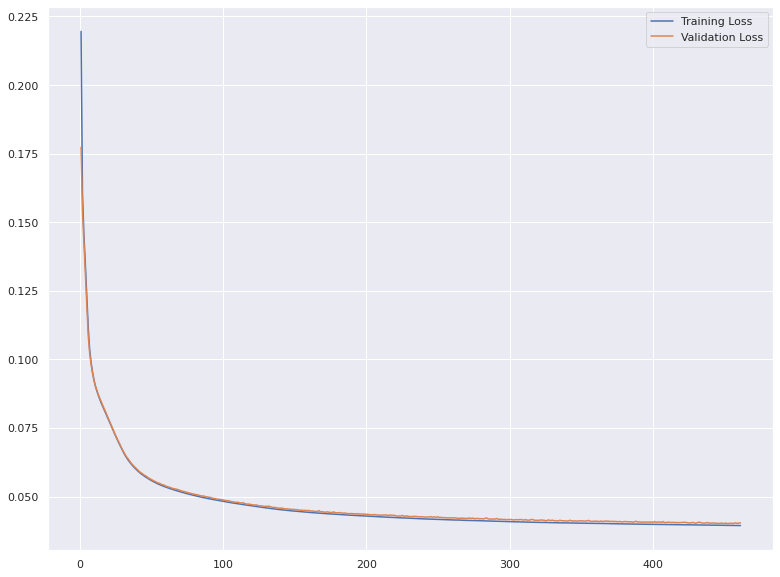

In [41]:
plot_train(losses,val_loss,start=0,last=-1)

# For inference only

In [19]:
model = torch.jit.load("PR_Net_2505.pth")
model.to(device)
with torch.no_grad():
    d = test_dataset[:]

    inputs = d[:,1:input_num+1]
    targets = d[:,input_num+1:input_num+5]
    predictions = model(inputs)

    inputs, predictions, targets = inputs.to('cpu').numpy(), predictions.to('cpu').numpy(), targets.to('cpu').numpy()

ValueError: The provided filename PR_Net_2505.pth does not exist

In [31]:
predictions_orig= predictions* sds[input_num:input_num+4].reshape(1, -1) + means[input_num:input_num+4].reshape(1, -1)
targets_orig= targets * sds[input_num:input_num+4].reshape(1, -1) + means[input_num:input_num+4].reshape(1, -1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

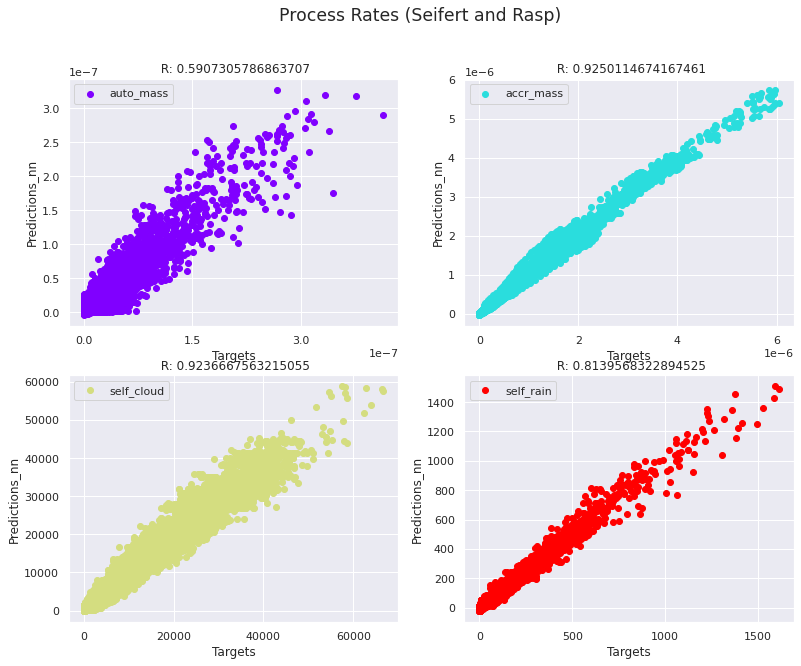

In [32]:
sns.set_theme(style="darkgrid")
Plotting.plot_predictions(targets_orig,predictions_orig,2,2,['auto_mass','accr_mass','self_cloud','self_rain'],"Process Rates (Seifert and Rasp)")

In [23]:
d= (d[:,1:].to('cpu').numpy()* sds[:].reshape(1, -1)) + means[:].reshape(1, -1)
moments=d[:,input_num+4:input_num+8]
meta_data=d[:,input_num+8:]

In [24]:
def EulerODE(auto,accr,sc_c,sc_r,moments,i):
    #Default setting as used in Seifert and Rasp. 5 second interval
    dt=5
    Lc=moments[0]
    Nc=moments[1]
    Lr=moments[2]
    Nr=moments[3]
    autoN = 1.0/xstar*auto
    accrN = accr/Xc3d[i]
    for i in range (8):
        Lc = Lc - auto*dt - accr*dt
        Lr = Lr + auto*dt + accr*dt
        Nc = Nc - accrN*dt - sc_c*dt
        Nr = Nr + autoN*dt - sc_r*dt
 
    return Lc,Nc,Lr,Nr
        
    

In [41]:

Xc3d = 4./3. * 3.14 * rhow * meta_data[:,0]**3
auto,accr,sc_c,sc_r=[predictions_orig[:,i] for i in range(4)]
moments_nn=[]
moments_true=[]
time=d[:,0]
for i in range (len(time)-1):
    if time[i]<time[i+1]:
        moments_true.append(moments[i+1,:]) #Because I have them with the data
        x=EulerODE(auto[i],accr[i],sc_c[i],sc_r[i],moments[i,:],i)
        moments_nn.append(x)

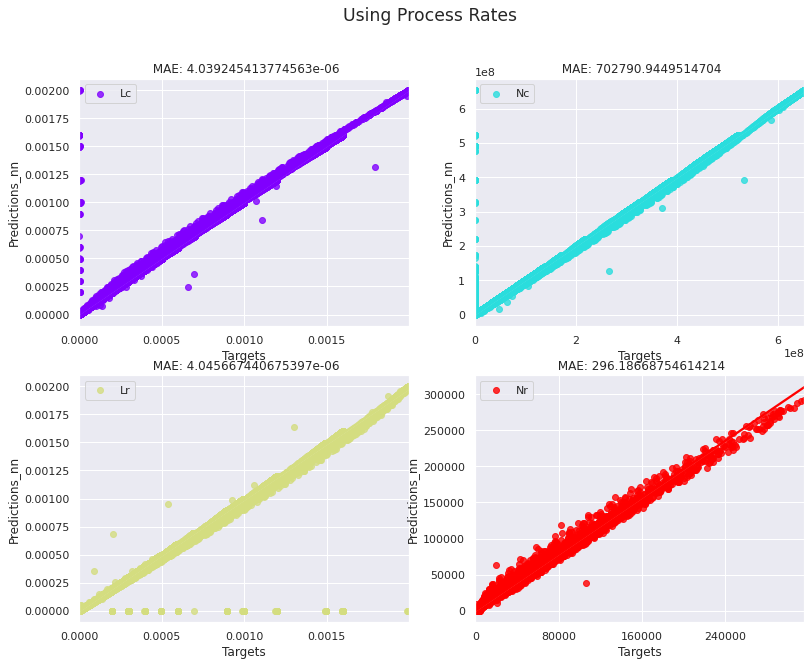

In [34]:
Plotting.plot_predictions_mm(np.asarray(moments_nn),np.asarray(moments_true),2,2,['Lc','Nc','Lr','Nr'],'Using Process Rates')

In [42]:
d = test_dataset[:]
inputs = d[2,1:input_num+1]
with torch.no_grad():
    print(model(inputs))
    traced_cell = torch.jit.trace(model, (inputs))
torch.jit.save(traced_cell, "/gpfs/work/sharmas/mc-snow-data/pr_runs/PR_Net_2505.pth")

tensor([-0.1677, -0.2376, -0.3000, -0.1644], device='cuda:0')
